In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.distributions import Normal
import math
import scipy.stats as stats

In [21]:
# parameters of data-generating distribution
prior_mean = 10; prior_std = 3; obs_std = 2; seq_length = 7

def bayesian_inference(inputs, prior_mean, prior_var, noise_var):
    """ Performs Bayesian inference for the given data-generating process.
    Args:
        inputs: PyTorch Tensor of shape (num_observations, batch_size, 1)
        
    Returns:
        m: PyTorch Tensor of shape (batch_size, 1)
        s: Float
    """
    n = inputs.shape[0]
    k = 1 / ((1 / prior_var) + (n / noise_var))
    m = k * ((inputs.sum(0) / noise_var) + (prior_mean / prior_var))
    s = math.sqrt(k + noise_var)
    return m, s

# sample data
mu = Normal(prior_mean * torch.ones(1), prior_std).sample((1000,))
x = Normal(mu, obs_std).sample((seq_length,))

# run Bayesian inference
m, s = bayesian_inference(x[:seq_length-1], prior_mean, prior_std ** 2, obs_std ** 2)
bayes_optimal_loss = -Normal(m, s).log_prob(x[-1]).mean()

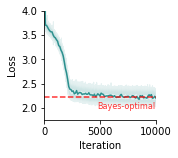

In [22]:
plt.rcParams["figure.figsize"] = (2.,2)

losses = torch.load('losses.pth')
losses_mean = losses.numpy().mean(0)
losses_std = losses.numpy().std(0) 

plt.plot(torch.arange(losses.shape[1])[::100] , losses_mean[::100], color='#007977', alpha=0.8)
plt.fill_between(torch.arange(losses.shape[1])[::1], losses_mean + losses_std, losses_mean - losses_std, color='#007977', alpha=0.1)
sns.despine()

plt.axhline(y=bayes_optimal_loss, xmin=0, xmax=losses.shape[1], ls='--', c='red', alpha=0.8)
plt.text(4750, 1.98, 'Bayes-optimal', c='red', alpha=0.8, size=8)

plt.xlim(0, 10000)
plt.ylim(1.75, 4)

plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.savefig('loss.pdf', bbox_inches='tight')

In [27]:
class MetaLearner(torch.nn.Module):
    def __init__(self, num_hidden=256):
        super(MetaLearner, self).__init__()
        
        self.rnn = torch.nn.LSTM(1, num_hidden)
        self.linear_mu = torch.nn.Linear(num_hidden, 1)
        self.linear_logstd = torch.nn.Linear(num_hidden, 1)

    def forward(self, inputs):
        """
        Args:
            inputs (Tensor): PyTorch tensor of size (seq_length, batch_size, 1)
        
        Returns:
            Normal object: Normal distribution object with dimensions (batch_size, 1)
        """
        hidden, _ = self.rnn(inputs)
        hidden = hidden[-1]
        
        mu = self.linear_mu(hidden)
        std = torch.exp(self.linear_logstd(hidden))
        
        return Normal(mu, std)

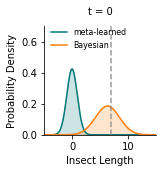

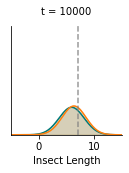

In [36]:
def plot_gaussian(mu, sigma, color):
    x = np.linspace(mu - 50*sigma, mu + 50*sigma, 1000)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color=color)
    plt.fill_between(x, stats.norm.pdf(x, mu, sigma), alpha=0.2, color=color)

iters = [0, 10000]

# generate test data
mu_test = torch.Tensor([[7]])
x_test = Normal(mu_test, obs_std).sample((seq_length,))

for i in iters:
    plt.figure(i)
    
    # meta-learned inference
    network = torch.load('trained_models/iter_' + str(i) + '.pth')
    predictive_posterior = network(x_test[:seq_length-1])
    
    # Bayesian inference
    m, s = bayesian_inference(x_test[:seq_length-1], prior_mean, prior_std ** 2, obs_std ** 2)

    with torch.no_grad():
        plt.rcParams["figure.figsize"] = (2.,2)
        plt.title('t = ' + str(i), y=1.05, size=10)
        plot_gaussian(predictive_posterior.loc[0, 0], predictive_posterior.scale[0, 0], color='#007977')
        plot_gaussian(m[seq_id, 0], s, color='C1')
        plt.xlabel('Insect Length')
        if i == 0:
            plt.ylabel('Probability Density')
            plt.legend(['meta-learned', 'Bayesian'], frameon=False, fontsize=7.9, loc=1, bbox_to_anchor=(0.8,1.05))
        else:
            plt.yticks([])
        plt.axvline(x=7, ymin=0, ymax=1, ls='--', c='grey', alpha=0.8)
        plt.ylim([0, 0.7])
        plt.xlim([-5, 15])
        sns.despine()
        plt.savefig(str(i) + '.pdf', bbox_inches='tight')
        